<a href="https://colab.research.google.com/github/Minh-Do02/IMDB-Movies-Review/blob/master/IIA_IMDB_Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Chargement et Exploration des Données

In [ ]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Téléchargement des ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('punkt_tab')



# 2. Affichage des fichiers dans le répertoire d'entrée pour trouver le bon chemin
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Chargement des données depuis le bon répertoire
#data = pd.read_csv('/kaggle/input/lakshmi25npathi-imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data = pd.read_csv(os.path.join(lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path, 'IMDB Dataset.csv'))

data['review'] = data['review'].str.lower()


# Encodage des sentiments (positive -> 1, negative -> 0)
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Nettoyage et tokenisation
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    return ' '.join(
        [word for word in word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]
    )

data['review_clean'] = data['review'].apply(clean_and_tokenize)
data.head()

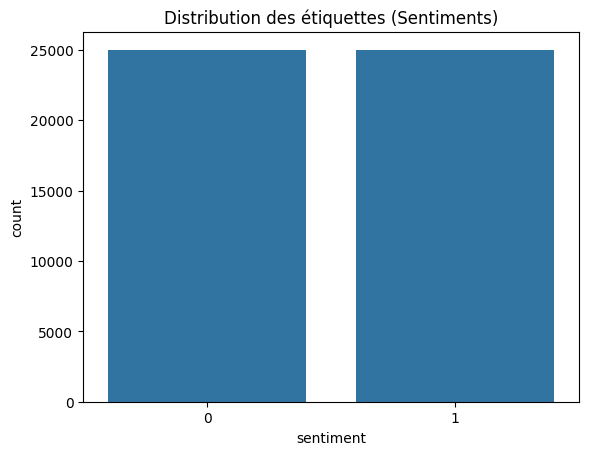

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

# Visualisation de la répartition des classes
sns.countplot(x="sentiment", data=data)
plt.title("Distribution des étiquettes (Sentiments)")
plt.show()

# Préparation des Données

### Prépare les séquences et appliquez le padding pour garantir que toutes les séquences ont la même longueur.

# Construction du Modèle


In [ ]:
from sklearn.tree import plot_tree

# Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['review_clean']).toarray()
y = data['sentiment']

# Division des données en ensembles d'entraînement, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Fonction pour évaluer les modèles et afficher la structure du modèle
def evaluate_model_and_show_details(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    # Affichage des résultats
    print(f"--- {model.__class__.__name__} ---")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))

    # Affichage de la structure du modèle
    print(f"\n--- {model.__class__.__name__} ---")

    if isinstance(model, DecisionTreeClassifier):
        # Affichage de la structure de l'arbre de décision
        plt.figure(figsize=(12, 8))
        plot_tree(model, filled=True, feature_names=vectorizer.get_feature_names_out(), class_names=["Negative", "Positive"], rounded=True, fontsize=10)
        plt.title(f"Decision Tree - Structure")
        plt.show()

    elif isinstance(model, RandomForestClassifier):
        # Affichage d'un arbre de Random Forest
        plt.figure(figsize=(12, 8))
        plot_tree(model.estimators_[0], filled=True, feature_names=vectorizer.get_feature_names_out(), class_names=["Negative", "Positive"], rounded=True, fontsize=10)
        plt.title(f"Random Forest - Un arbre du modèle")
        plt.show()

    elif isinstance(model, SVC):
        # Affichage des hyperparamètres du SVM
        print("Hyperparamètres du modèle SVM :")
        print(model.get_params())

    # Calcul des métriques
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    # Affichage du rapport de classification
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Courbe ROC et AUC
    if y_pred_prob is not None:
        auc = roc_auc_score(y_val, y_pred_prob)
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC = {auc:.2f})")
        metrics["AUC"] = auc

    return metrics



--- DecisionTreeClassifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3750
           1       0.72      0.72      0.72      3750

    accuracy                           0.72      7500
   macro avg       0.72      0.72      0.72      7500
weighted avg       0.72      0.72      0.72      7500


--- DecisionTreeClassifier ---


<Figure size 1000x800 with 0 Axes>

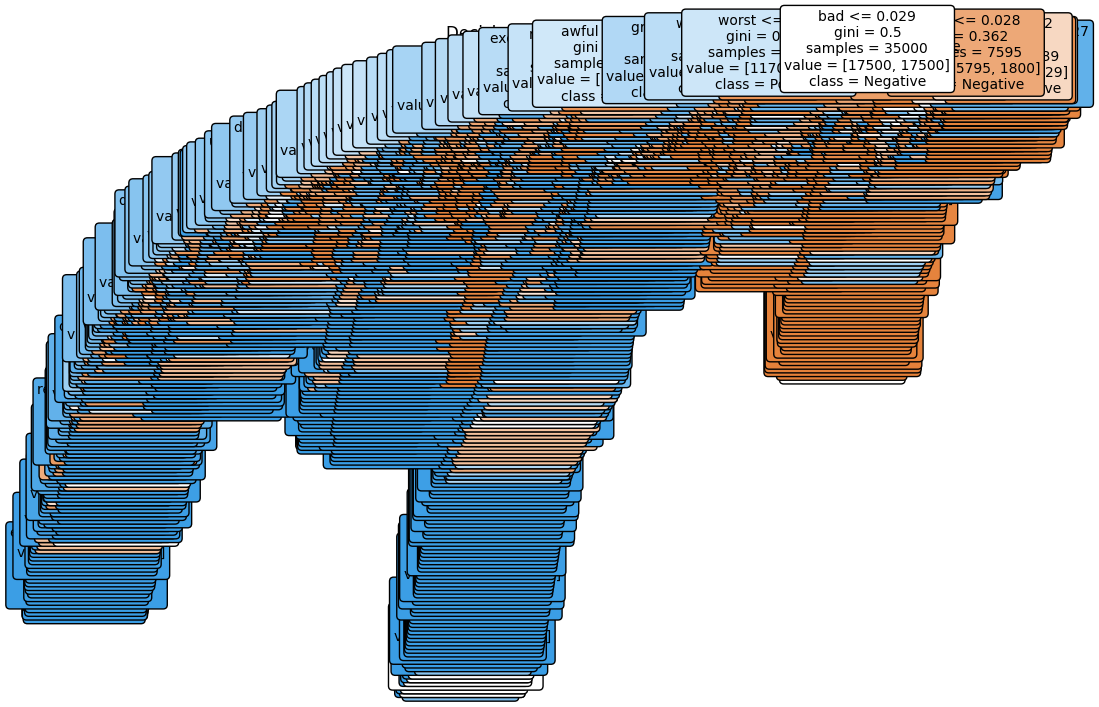


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3750
           1       0.72      0.72      0.72      3750

    accuracy                           0.72      7500
   macro avg       0.72      0.72      0.72      7500
weighted avg       0.72      0.72      0.72      7500



In [ ]:
# Initialisation des modèles
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Résultats des modèles supervisés
results = {}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    metrics = evaluate_model_and_show_details(model, X_train, y_train, X_val, y_val)
    results[name] = metrics



--- DecisionTreeClassifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      3750
           1       0.72      0.73      0.72      3750

    accuracy                           0.72      7500
   macro avg       0.72      0.72      0.72      7500
weighted avg       0.72      0.72      0.72      7500


--- DecisionTreeClassifier ---


<Figure size 1000x800 with 0 Axes>

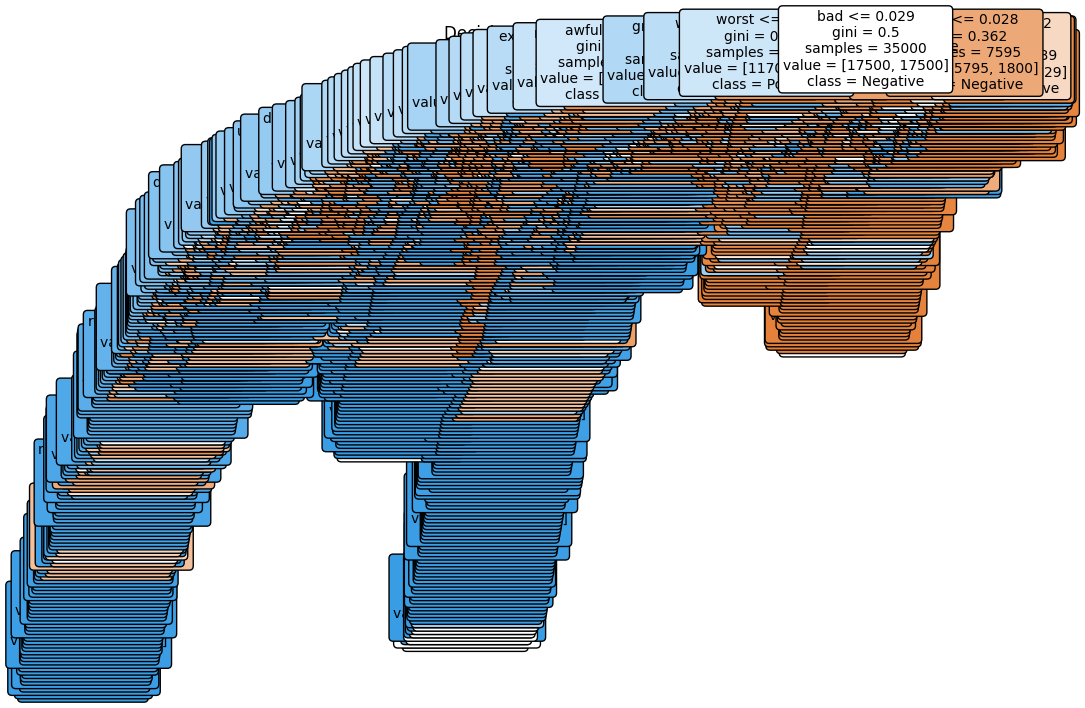


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      3750
           1       0.72      0.73      0.72      3750

    accuracy                           0.72      7500
   macro avg       0.72      0.72      0.72      7500
weighted avg       0.72      0.72      0.72      7500



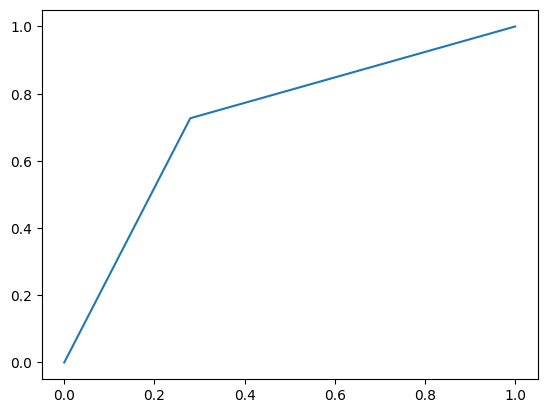

In [ ]:
# Initialisation des modèles
models = {
    "Decision Tree": DecisionTreeClassifier()
}

# Résultats des modèles supervisés
results = {}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    metrics = evaluate_model_and_show_details(model, X_train, y_train, X_val, y_val)
    results[name] = metrics


--- RandomForestClassifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3750
           1       0.86      0.82      0.84      3750

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500


--- RandomForestClassifier ---


<Figure size 1000x800 with 0 Axes>

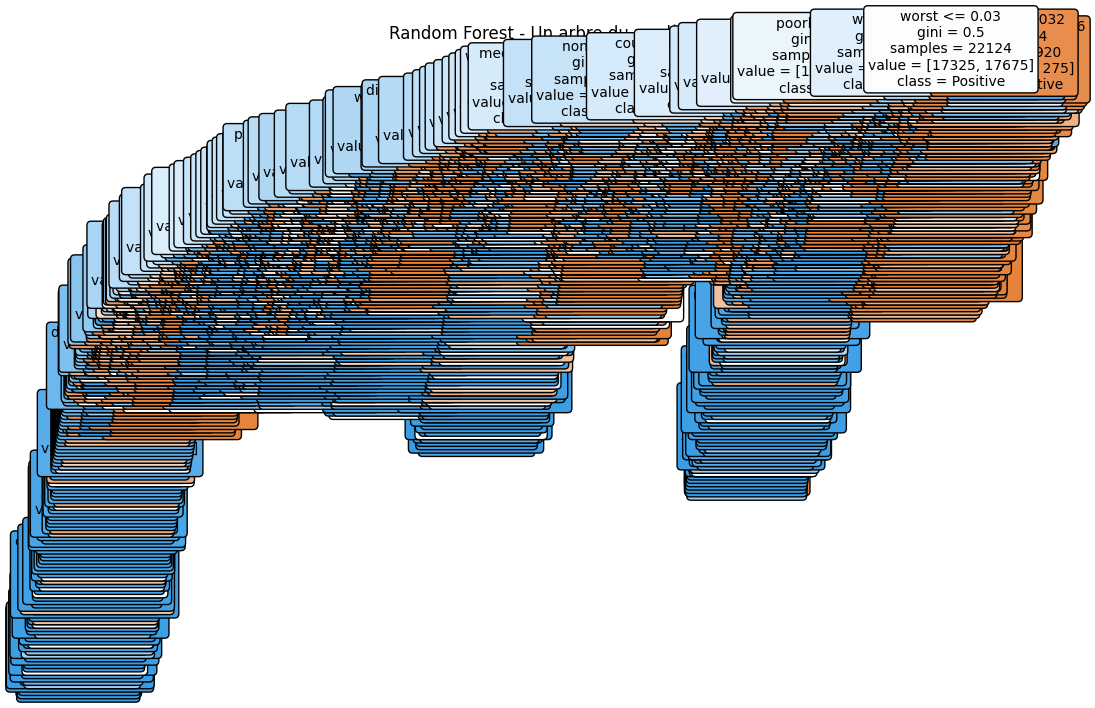


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3750
           1       0.86      0.82      0.84      3750

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500



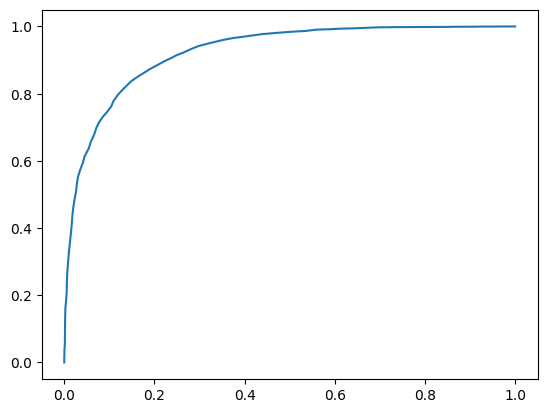

In [ ]:
# Initialisation des modèles
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# Résultats des modèles supervisés
results = {}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    metrics = evaluate_model_and_show_details(model, X_train, y_train, X_val, y_val)
    results[name] = metrics


In [ ]:
# Affichage de la courbe ROC
plt.title("Courbes ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Résumé des résultats
results_df = pd.DataFrame(results).T
print("\nRésumé des performances :")
print(results_df)

In [ ]:
# Sauvegarde des résultats
results_df.to_csv("model_performance.csv")

# Sauvegarde du modèle
model.save("model.keras")

# Prédiction

In [ ]:
# Charger le modèle sauvegardé
from tensorflow.keras.models import save_model, load_model

model = load_model('lstm_model.keras')


In [ ]:
# Faire des prédictions sur les données de validation
val_predictions = model.predict(X_val_lstm)

# Convertir les probabilités en classes
val_predicted_classes = (val_predictions > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


In [ ]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_val, val_predicted_classes))


              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      4961
         1.0       0.86      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



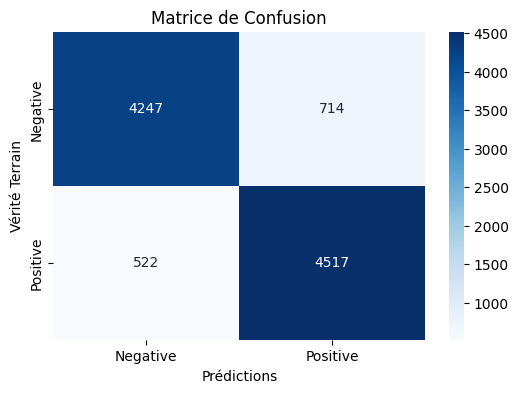

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, val_predicted_classes)

# Visualiser la matrice
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Prédictions')
plt.ylabel('Vérité Terrain')
plt.title('Matrice de Confusion')
plt.show()


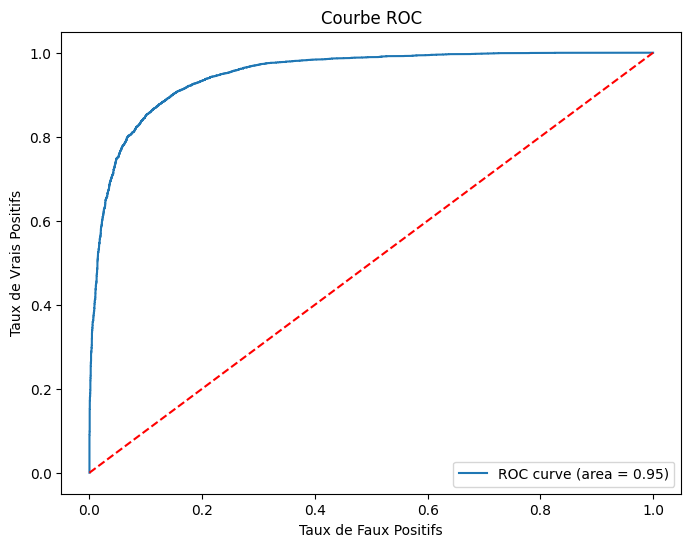

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonale pour le hasard
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()
